In [7]:
import geopandas as gpd
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/christopher.x.ren/.config/earthengine/earthindex-7d2c9b94c507.json'

v2_detections = gpd.read_parquet(
    'gs://demeter-labs/tea/detections/v2_detections_prob_0.9_postprocess.parquet')
ra_polygons = gpd.read_file(
    "gs://demeter-labs/tea/geometries/ra_data/subsets/Indonesia_Tea_polygons.geojson")
v2_det_8 = gpd.read_parquet("gs://demeter-labs/tea/detections/tile_classifier_predictions_v2_java-sumatra_prob_0.8_postprocess.parquet")
v2_det_7 = gpd.read_parquet("gs://demeter-labs/tea/detections/tile_classifier_predictions_v2_java-sumatra_prob_0.7_postprocess.parquet")
v2_det_6 = gpd.read_parquet("gs://demeter-labs/tea/detections/tile_classifier_predictions_v2_java-sumatra_prob_0.6_postprocess.parquet")
v2_det_5 = gpd.read_parquet("gs://demeter-labs/tea/detections/tile_classifier_predictions_v2_java-sumatra_prob_0.5_postprocess.parquet")
ra_points = gpd.read_file("gs://demeter-labs/tea/geometries/ra_data/subsets/Indonesia_Tea_points.geojson")

In [9]:
from ipyleaflet import Map, GeoData, LayersControl, WidgetControl
from ipywidgets import IntSlider, VBox, HTML
import ipyleaflet as ipyl
import ee
import shapely
import sys
sys.path.append('../src')

from gee import get_s2_hsv_median, get_ee_image_url
# Define basemap tiles and helper functions
BASEMAP_TILES = {
    'GOOGLE_HYBRID': 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
}

BOUNDARY_PATH = "/home/christopher.x.ren/earth-index-ml/places/ra_aoi_indonesia.geojson"
BOUNDARY = gpd.read_file(BOUNDARY_PATH)

hsv_median = get_s2_hsv_median(
    ee.Geometry(shapely.geometry.mapping(BOUNDARY.geometry.iloc[0])), '2023-01-01', '2024-12-31')

# Get tile URL
hsv_url = get_ee_image_url(hsv_median, {
    'min': [0, 0, 0],
    'max': [1, 1, 1],
    'bands': ['hue', 'saturation', 'value']
})
BASEMAP_TILES['HSV_MEDIAN'] = hsv_url

# Create base map with basemap toggle control
current_basemap = 'GOOGLE_HYBRID'
basemap_layer = ipyl.TileLayer(url=BASEMAP_TILES[current_basemap], no_wrap=True, name='basemap')
m = Map(basemap=basemap_layer, center=(-2, 120), zoom=5, height='1200px', scroll_wheel_zoom=True)


m = Map(center=(-2, 120), zoom=5, height='1200px', scroll_wheel_zoom=True)

# Add RA polygons layer
ra_style = {
    'color': 'blue',
    'fillColor': 'blue',
    'fillOpacity': 0.1,
    'weight': 1
}
ra_layer = GeoData(geo_dataframe=ra_polygons, style=ra_style, name='RA Polygons')
m.add_layer(ra_layer)


v2_style_5 = {
    'color': 'purple',
    'fillColor': 'purple', 
    'fillOpacity': 0.9,
    'weight': 1
}
v2_layer_5 = GeoData(geo_dataframe=v2_det_5, style=v2_style_5, name='V2 Detections 50%')
m.add_layer(v2_layer_5)

min_area = int(v2_detections['area'].min())
max_area = min(min_area * 20, int(v2_detections['area'].max()))
area_slider = IntSlider(
    value=min_area,
    min=min_area,
    max=max_area,
    step=min_area,
    description='Min Area:',
    continuous_update=False
)

def update_v2_layer(change):
    filtered_data = v2_detections[v2_detections['area'] >= change['new']]
    v2_layer.geo_dataframe = filtered_data

area_slider.observe(update_v2_layer, names='value')

# Add controls
control = WidgetControl(widget=VBox([area_slider]), position='topright')
m.add_control(control)
m.add_control(LayersControl())
# toggle_control = ipyl.WidgetControl(widget=toggle_basemap_button, position='topright')
# m.add_control(toggle_control)

m


Map(center=[-2, 120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [6]:
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

def process_detection_df(det_tuple):
    det_name, det_df = det_tuple
    results = []
    for i in tqdm(range(1, 21)):
        area_threshold = i * 102399
        
        # Filter detections by area threshold
        filtered_detections = det_df[det_df['area'] >= area_threshold]
        
        if len(filtered_detections) > 0:
            # Get centroid to determine UTM zone
            filtered_union = filtered_detections.geometry.union_all()
            centroid = filtered_union.centroid
            utm_zone = int(((centroid.x + 180) / 6) % 60) + 1
            hemisphere = 'N' if centroid.y >= 0 else 'S'
            utm_crs = f"EPSG:{'326' if hemisphere == 'N' else '327'}{utm_zone:02d}"
            
            # Project both datasets to UTM
            filtered_union_utm = gpd.GeoDataFrame(
                geometry=[filtered_union], crs=filtered_detections.crs).to_crs(utm_crs)
            ra_union_utm = gpd.GeoDataFrame(
                geometry=[ra_polygons.geometry.union_all()], crs=ra_polygons.crs).to_crs(utm_crs)
            
            # Calculate intersection
            intersection = filtered_union_utm.geometry.intersection(ra_union_utm.geometry)
            
            if not intersection.is_empty.iloc[0]:
                # Calculate total area of intersection
                intersection_area = intersection.area.iloc[0]
                # Calculate total area of RA polygons
                ra_area = ra_union_utm.geometry.area.iloc[0]
                # Calculate coverage percentage
                coverage_pct = (intersection_area / ra_area) * 100
            else:
                coverage_pct = 0
        else:
            coverage_pct = 0
            
        results.append({
            'model': det_name,
            'area_threshold': area_threshold,
            'coverage_percentage': coverage_pct
        })
    return results

# Process detection dataframes in parallel
detection_dfs = [
    ('v2_0.7', v2_det_7), 
    ('v2_0.6', v2_det_6), 
    ('v2_0.8', v2_det_8), 
    ('v2_0.9', v2_detections), 
    ('v2_0.5', v2_det_5)
]

coverage_results = Parallel(n_jobs=len(detection_dfs), verbose=10)(
    delayed(process_detection_df)(det_tuple) for det_tuple in detection_dfs
)

# Flatten results and convert to DataFrame
coverage_df = pd.DataFrame([
    result for sublist in coverage_results for result in sublist
])


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
100%|██████████| 20/20 [00:14<00:00,  1.38it/s]
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.0s remaining:   22.5s
100%|██████████| 20/20 [00:14<00:00,  1.36it/s]
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   15.2s remaining:   10.1s
100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.0s finished


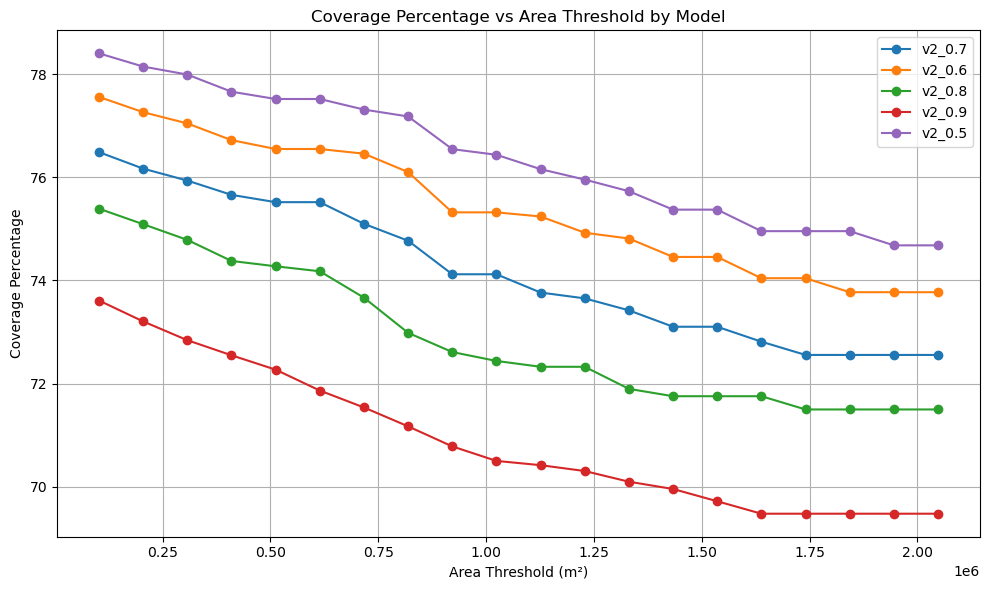

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for model in coverage_df['model'].unique():
    model_data = coverage_df[coverage_df['model'] == model]
    plt.plot(model_data['area_threshold'], model_data['coverage_percentage'], label=model, marker='o')

plt.xlabel('Area Threshold (m²)')
plt.ylabel('Coverage Percentage')
plt.title('Coverage Percentage vs Area Threshold by Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('coverage_percentage_vs_area_threshold.png', dpi=300)